We're interested in predicting accidents at specific times in the day. We need to have some idea of traffic flow, so that we don't falsely assume  an increase in accidents is due to more accidents, and not just the natural flow of the traffic.

The data we will use to normalize the accidents is this:
These data include the street and direction of the traffic, however no coordinate data so we won't easily be able to normalize traffic by geographical location. Instead, we can adjust the accident data by the hour based on the traffic flow.

I plan to look at traffic count data, and determine the average traffic in a 24 hour period. I will then noramlize this, and then all traffic data throughout the day could be adjusted to these values. Then the accidents are noremalized to the normal traffic patterns!

1. Find consecutive days of traffic where all hours have values
2. Average the values over the number of days
3. Express each hour's traffic as a percent of the peak hour. This is the value that we will adjust the accident data by.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
#read in the accident data. Read in full data, then will have to calculate counts. Want to do this
#so that we can do alternate analyses later.
accident_df = pd.read_csv('accident_df.csv', parse_dates=True)
#set date  type to datetime64
accident_df.datetime = accident_df.datetime.astype("datetime64")
accident_df.date = accident_df.date.astype("datetime64")
accident_df.time = accident_df.time.astype("datetime64")
# set datetime column to index. Unsure why not dropping 'datetime' column
accident_df.set_index(pd.DatetimeIndex(accident_df['datetime']), inplace=True, drop=True)
accident_df.head()

/Users/gene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,datetime,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime.1
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,2019-04-16,2019-09-08,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16 00:00:00


In [5]:
#read in the normalization data calculated from the traffic volume data
hourly_volume_norm = pd.read_csv('hourly_volume_norm.csv', header=None, names=['hour', 'fraction'])
hourly_volume_norm.head()

,hour,fraction
0,00:00:00,0.395687
1,01:00:00,0.278726
2,02:00:00,0.208978
3,03:00:00,0.183593
4,04:00:00,0.218415


Each entry in the database is an accident that was logged by NYPD. Therefore, we can get an hourly accident count by simply counting the number of entries per hour per day.

In [7]:
accident_df.date.min(), accident_df.date.max()

(Timestamp('2012-07-01 00:00:00'), Timestamp('2019-04-16 00:00:00'))

In [8]:
accident_df.head()

,datetime,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime.1
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,2019-04-16,2019-09-08,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16 00:00:00
2019-04-16,2019-04-16,2019-04-16,2019-09-08,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16 00:00:00


In [ ]:
#limited_accident_df = accident_df.loc['2014-09-13':'2019-04-16']
#hourly_count = limited_accident_df['date'].resample('H').count()
accident_counts_final = pd.Series(hourly_count.values)
accident_counts_final

In [17]:
len(accident_counts_final)

40248

In [18]:
#trying to get values saved in dict with date and time so can easily slice
accidents_counts = []
for i_int, i in enumerate(pd.date_range(start='2014-09-13', end='2019-04-16', freq='D').date):
    for j_int, j in enumerate(pd.date_range(start='0:00', end='23:00', freq='H').time):
        accidents_counts.append({'date': str(i), 'time': str(j)})

In [21]:
accidents_counts[0]


{'date': '2014-09-13', 'time': '00:00:00'}

In [26]:

accidents_counts_df = pd.DataFrame(data=accidents_norm)
accidents_counts_df.head()
accidents_counts_df['counts'] = accident_counts_final
accidents_counts_df.head()



,date,time,counts
0,2014-09-13,00:00:00,17
1,2014-09-13,01:00:00,21
2,2014-09-13,02:00:00,10
3,2014-09-13,03:00:00,7
4,2014-09-13,04:00:00,15


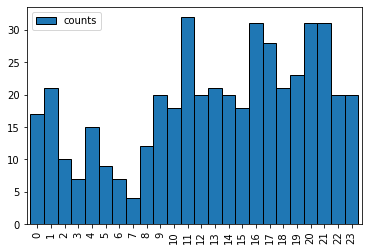

In [33]:
accidents_counts_df[accidents_counts_df['date'] == '2014-09-13'].plot.bar(width=1, edgecolor='k')

In [44]:
test = accidents_counts_df.counts / hourly_volume_norm.fraction


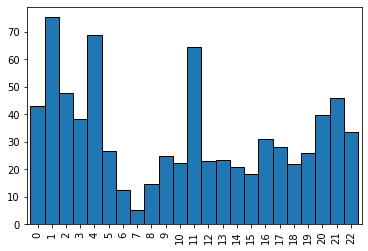

In [45]:
test.iloc[0:23].plot.bar(width=1, edgecolor='k')

# REGRESSION

In [52]:
#preparing data
# Convert the date into a number (of days since some point)

#accidents_counts_df['datetime'] = pd.to_datetime(accidents_counts_df['date'] + ' ' + \
     #   accidents_counts_df['time'])

accidents_counts_df.index.values

array([    0,     1,     2, ..., 40245, 40246, 40247])

In [47]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [65]:
X_train, X_test, y_train, y_test = train_test_split(accidents_counts_df.index.values, \
                            accidents_counts_df['counts'], test_size=0.2, random_state=27)


In [74]:
X_train = np.reshape(X_train, (-1,1))
X_test = np.reshape(X_test, (-1,1))



In [76]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)

m = RandomForestRegressor(n_estimators=50)
m.fit(X_train, y_train)
print_score(m)

[2.870137937817299, 7.6953701237572005, 0.9589878881740652, 0.710719291568234]
